In [1]:
import os
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import math
import json

from matplotlib.ticker import MultipleLocator

from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase import pdfmetrics
from reportlab.lib.utils import ImageReader

from stream_analysis.env_ import Env_
from stream_analysis.chat import Chat
from stream_analysis.summary import Summary

%matplotlib inline

In [2]:
def minutes_to_hhmm(minutes):
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    return f'{hours:02d}:{mins:02d}'

def get_word_freq(array):
    text_vectorizer = CountVectorizer(stop_words='english', encoding='utf8')
    X = text_vectorizer.fit_transform(array)
    word_freq = pd.DataFrame(
        X.toarray(), columns=text_vectorizer.get_feature_names_out())
    word_freq = word_freq.sum().sort_values(ascending=False)
    return word_freq


def draw_markdown_to_pdf(canvas, text, cursor, margin, width, height, font_name):
    # 轉換 Markdown 到純文本
    paragraphs = text.split('\n')

    canvas.setFont(font_name, 8)
    for paragraph in paragraphs:
        lines = paragraph.split('\n')
        for line in lines:
            # 計算每一行文本的寬度並進行多行處理
            if cursor < 50:  # 確保不超出頁面底部
                canvas.showPage()
                cursor = height - 50
            text_width = canvas.stringWidth(line, font_name, 12)
            if text_width > width:
                # 如果行寬超出可用寬度，進行換行處理
                words = line.split(' ')
                current_line = ""
                for word in words:
                    if canvas.stringWidth(current_line + word, font_name, 12) > width:
                        canvas.drawString(margin, cursor, current_line.strip())
                        cursor -= 15
                        current_line = word + ' '
                    else:
                        current_line += word + ' '
                if current_line:
                    canvas.drawString(margin, cursor, current_line.strip())
                    cursor -= 15
            else:
                canvas.drawString(margin, cursor, line.strip())
                cursor -= 15
    return cursor

In [3]:
env_ = Env_(video_live_url='https://www.youtube.com/live/xSHw_eNgEIM?si=XWo6DM6mhtjKW2BS')

with open(env_.video_data_path, 'w', encoding='utf8') as f:
    json.dump(env_.video_data, f, indent=2, ensure_ascii=False)

In [4]:
chat = Chat(env_)
df = chat.get()
chat.df_per_min.to_csv(env_.chat_per_min_csv_path, index=False)

In [5]:
chat.hightlight_urls

['https://youtube.com/watch?v=xSHw_eNgEIM&t=1m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=23m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=33m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=44m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=55m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=73m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=83m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=98m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=105m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=113m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=132m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=136m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=142m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=152m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=168m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=180m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=186m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=207m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=211m',
 'https://youtube.com/watch?v=xSHw_eNgEI

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22535 entries, 0 to 22534
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   author_id                   22535 non-null  object 
 1   author_name                 22535 non-null  object 
 2   author_title                22535 non-null  object 
 3   author_membership_duration  22535 non-null  int64  
 4   author_badge                22535 non-null  object 
 5   author_image                22535 non-null  object 
 6   message                     22535 non-null  object 
 7   message_without_emotes      22535 non-null  object 
 8   cleaned_message             22535 non-null  object 
 9   message_type                22535 non-null  object 
 10  money                       22535 non-null  float64
 11  time_in_seconds             22535 non-null  float64
 12  timestamp                   22535 non-null  int64  
 13  time_in_minutes             225

In [7]:
df.head()

author_id     author_name author_title  \
0  UCvqCq8lbpiZ9Ueks784u4oQ            Rave       member   
1  UCka95ZsvD7P4tT7a2A9r-uA   Crazesergeant       member   
2  UCr4zekP8VkAomxp3H0utOew  KuriousEmbrace                
3  UChpLoCOX1bhtDuSrKRsInPQ     Dongerbread       member   
4  UCRlKp8Z8dHpfsYB-fbsIAEg      Ran Bindoy       member   

   author_membership_duration  \
0                        1095   
1                         180   
2                           0   
3                        1095   
4                         365   

                                        author_badge  \
0  https://yt3.ggpht.com/vPMJm64_X3uH9dgKzmZ_udFs...   
1  https://yt3.ggpht.com/5soInI8jLqQrqNXv8r3Ewtfu...   
2                                                      
3  https://yt3.ggpht.com/vPMJm64_X3uH9dgKzmZ_udFs...   
4  https://yt3.ggpht.com/F0YU4PUesWXUyOENvw51yhHC...   

                                        author_image  \
0  https://yt4.ggpht.com/ytc/AIdro_kq75F1RBiVRAM-...   
1  https://yt4.ggpht.com/jRNzbPA-baHgOrNwQxifEvtO...   
2  https://yt4.ggpht.com/ytc/AIdro_nzTtI6dXn-Cu4_...   
3  https://yt4.ggpht.com/cJ0tfAwAWm0l7f487NekddTY...   
4  https://yt4.ggpht.com/ytc/AIdro_muInEf7j4pqB5a...   

                                 message  \
0  Time to bring peace to these streets    
1                         Howdy Eupator5   
2      Good morning day and evening chat   
3                         One last ride    
4   :_deadbeats::_deadbeats::_deadbeats:   

                  message_without_emotes  \
0  Time to bring peace to these streets    
1                         Howdy Eupator5   
2      Good morning day and evening chat   
3                         One last ride    
4                                          

                        cleaned_message  message_type  money  time_in_seconds  \
0  Time to bring peace to these streets  text_message    0.0            6.102   
1                        Howdy Eupator5  text_message    0.0            8.091   
2             morning  and evening chat  text_message    0.0            8.612   
3                             last ride  text_message    0.0            9.302   
4                                        text_message    0.0           10.625   

          timestamp  time_in_minutes  
0  1727085620653007                0  
1  1727085622642628                0  
2  1727085623121301                0  
3  1727085623856848                0  
4  1727085625151213                0

In [8]:
df['message'].nunique()

14527

In [9]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

c:\Users\asus\Documents\Test\test\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\asus\Documents\Test\test\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model train

In [10]:
df_cleaned = df[df['cleaned_message'].str.len() > 0][['author_id', 'message', 'cleaned_message']]
df_cleaned

author_id                                message  \
0      UCvqCq8lbpiZ9Ueks784u4oQ  Time to bring peace to these streets    
1      UCka95ZsvD7P4tT7a2A9r-uA                         Howdy Eupator5   
2      UCr4zekP8VkAomxp3H0utOew      Good morning day and evening chat   
3      UChpLoCOX1bhtDuSrKRsInPQ                         One last ride    
5      UCm_35i5puywsoj-fv2k_LlQ                              mori doko   
...                         ...                                    ...   
22530  UCwZsQPDCpgflaFHZSuq5-0Q                                 Peace    
22531  UCzuRdHfr3kwaYPJvjyfBU5A                            :_RipP:eace   
22532  UCKkILxld9WRWfpYpaP5V3bQ            take care everyone :skull:7   
22533  UCwDJNKVHfcFiSPoOl1GNFkA                            :_RipP:EACE   
22534  UCD6enu5eVEwuhj0G9wJBrsg                            Take care!!   

                            cleaned_message  
0      Time to bring peace to these streets  
1                            Howdy Eupator5  
2                 morning  and evening chat  
3                                 last ride  
5                                 mori doko  
...                                     ...  
22530                                 Peace  
22531                                 Peace  
22532                               care  7  
22533                                 PEACE  
22534                                  care  

[14320 rows x 3 columns]

In [11]:
from scipy.special import softmax

def get_sentiment(message):
    encoded_input = tokenizer(message, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    sentiment_scores = {}
    
    for i in range(scores.shape[0]):
        l = config.id2label[i]
        sentiment_scores[l.lower()] = float(scores[i])
    
    return sentiment_scores['neutral'], sentiment_scores['negative'], sentiment_scores['positive']


In [12]:
msg = df_cleaned['cleaned_message'].iloc[5]
display(msg)
get_sentiment(msg)

'feel like bringing peace to holo Santos is like pushing sisyphuss boulder'

(0.6531980037689209, 0.22518141567707062, 0.12162058800458908)

In [13]:
df['message_without_emotes'].nunique()

13615

In [14]:
df['cleaned_message'].nunique()

11779

In [15]:
chat.df_per_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   time_in_minutes          356 non-null    int64  
 1   active_users             356 non-null    int64  
 2   membership_duration_avg  356 non-null    float64
 3   money_sum                356 non-null    float64
 4   messages                 356 non-null    int64  
 5   message_without_emotes   356 non-null    int64  
 6   cleaned_messages         356 non-null    int64  
 7   member_messages          356 non-null    int64  
 8   messages_moving_avg      356 non-null    float64
 9   is_above_average         356 non-null    bool   
dtypes: bool(1), float64(3), int64(6)
memory usage: 25.5 KB


In [16]:
chat.df_per_min.head()

time_in_minutes  active_users  membership_duration_avg  money_sum  \
0                0            27               403.333333   0.000000   
1                1            63               361.666667   0.000000   
2                2            48               370.769231   5.000000   
3                3            31               372.804878   0.000000   
4                4            53               338.642857   6.926291   

   messages  message_without_emotes  cleaned_messages  member_messages  \
0        33                      21                19               22   
1        81                      34                32               57   
2        65                      38                36               43   
3        41                      14                14               34   
4        70                      34                30               49   

   messages_moving_avg  is_above_average  
0            63.272472             False  
1            63.272472              True  
2            63.272472              True  
3            63.272472             False  
4            63.272472              True

In [17]:
chat.df_per_min.drop(columns=['time_in_minutes', 'messages_moving_avg']).describe()

active_users  membership_duration_avg   money_sum    messages  \
count    356.000000               356.000000  356.000000  356.000000   
mean      49.660112               410.954896    0.932982   63.272472   
std       32.374041                84.245073    7.406910   45.974229   
min       11.000000                70.000000    0.000000   12.000000   
25%       28.000000               358.559243    0.000000   34.000000   
50%       40.000000               412.829787    0.000000   47.000000   
75%       60.000000               462.265957    0.000000   77.250000   
max      191.000000               659.000000  133.126712  291.000000   

       message_without_emotes  cleaned_messages  member_messages  
count              356.000000        356.000000       356.000000  
mean                48.570225         40.224719        39.778090  
std                 32.637801         24.931344        29.418662  
min                 11.000000          8.000000         3.000000  
25%                 27.750000         24.000000        21.000000  
50%                 38.000000         33.000000        31.000000  
75%                 58.000000         49.000000        48.000000  
max                211.000000        210.000000       171.000000

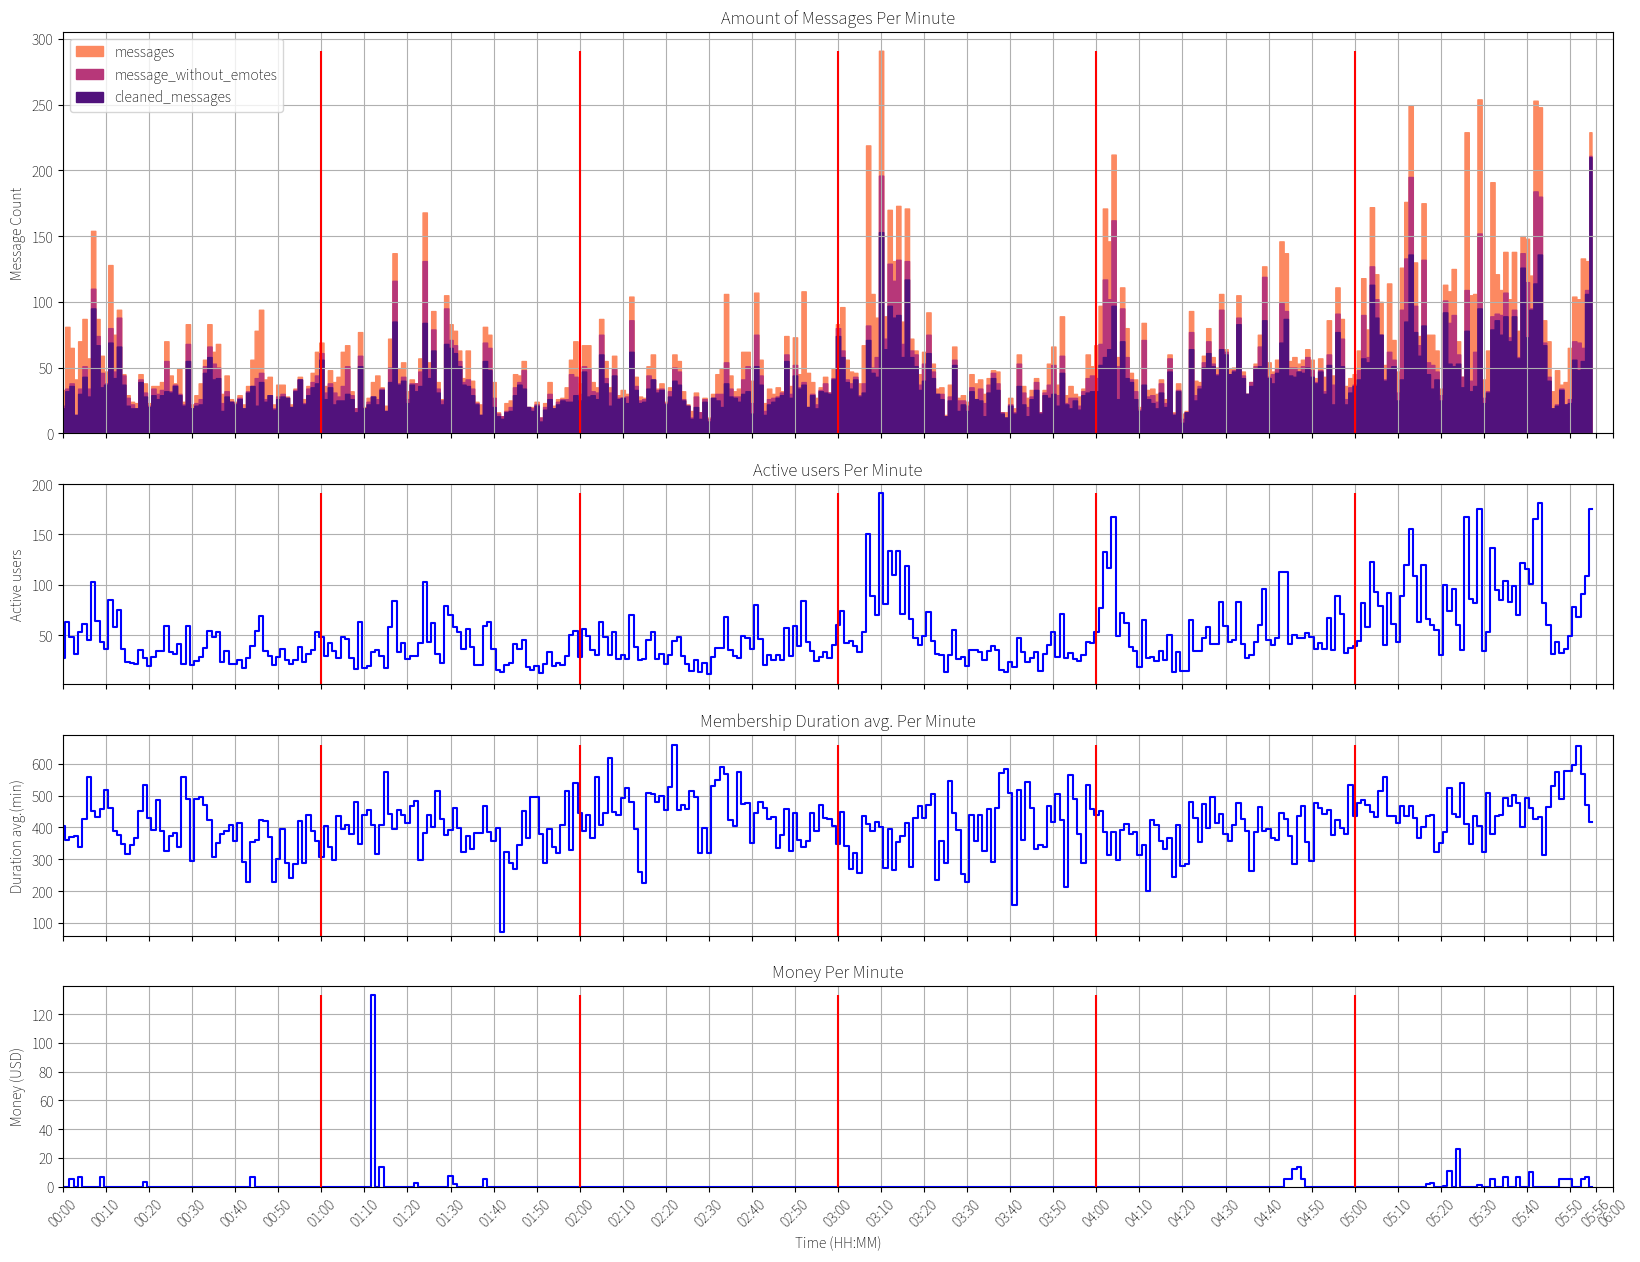

In [18]:
from stream_analysis.charts import ActivityPerMin

activity_per_min = ActivityPerMin(chat, env_)

In [19]:
chat.df_peaks

time_in_minutes  active_users  membership_duration_avg  money_sum  \
7                  7           103               452.305195   0.000000   
84                84           103               382.708333   0.000000   
187              187           150               410.525114   0.000000   
190              190           191               401.357388   0.000000   
192              192           134               394.264706   0.000000   
194              194           134               355.057803   0.000000   
196              196           119               415.263158   0.000000   
242              242           133               385.730994   0.000000   
244              244           167               385.707547   0.000000   
304              304           123               449.244186   0.000000   
312              312           120               436.619318   0.000000   
313              313           155               466.044177   0.000000   
316              316           120               401.193182   0.000000   
326              326           167               410.786026   0.000000   
329              329           175               403.602362   0.897897   
332              332           137               378.717277   5.000000   
342              342           165               426.600791   0.000000   
343              343           181               433.991935   0.000000   
355              355           175               416.331878   0.000000   

     messages  message_without_emotes  cleaned_messages  member_messages  \
7         154                     110                95              111   
84        168                     131                84              103   
187       219                      82                71              133   
190       291                     196               153              171   
192       170                     129                97               96   
194       173                     132                90               89   
196       171                     131               117              104   
242       171                     117                58               97   
244       212                     162                97              126   
304       172                     127               113              120   
312       176                     133                85              106   
313       249                     195               136              161   
316       175                     132                82               97   
326       229                     109                78              145   
329       254                     152                95              157   
332       191                      89                79              122   
342       253                     184               114              162   
343       248                     180               136              160   
355       229                     211               210              148   

     messages_moving_avg  is_above_average  
7              63.272472              True  
84             66.900000              True  
187            73.200000              True  
190           105.400000              True  
192           116.100000              True  
194           137.200000              True  
196           152.300000              True  
242            60.300000              True  
244            89.600000              True  
304            79.700000              True  
312           105.800000              True  
313           122.800000              True  
316           121.400000              True  
326            93.500000              True  
329           118.700000              True  
332           122.700000              True  
342           135.700000              True  
343           148.400000              True  
355            92.000000              True

In [20]:
chat.activity_ranges

[(np.int64(1), np.int64(13)),
 (np.int64(23), np.int64(29)),
 (np.int64(33), np.int64(36)),
 (np.int64(44), np.int64(46)),
 (np.int64(55), np.int64(69)),
 (np.int64(73), np.int64(79)),
 (np.int64(83), np.int64(91)),
 (np.int64(98), np.int64(99)),
 (np.int64(105), np.int64(107)),
 (np.int64(113), np.int64(128)),
 (np.int64(132), np.int64(132)),
 (np.int64(136), np.int64(137)),
 (np.int64(142), np.int64(143)),
 (np.int64(152), np.int64(161)),
 (np.int64(168), np.int64(172)),
 (np.int64(180), np.int64(182)),
 (np.int64(186), np.int64(196)),
 (np.int64(207), np.int64(207)),
 (np.int64(211), np.int64(217)),
 (np.int64(222), np.int64(232)),
 (np.int64(238), np.int64(246)),
 (np.int64(257), np.int64(257)),
 (np.int64(262), np.int64(273)),
 (np.int64(278), np.int64(279)),
 (np.int64(283), np.int64(284)),
 (np.int64(294), np.int64(297)),
 (np.int64(301), np.int64(316)),
 (np.int64(323), np.int64(343)),
 (np.int64(351), np.int64(355))]

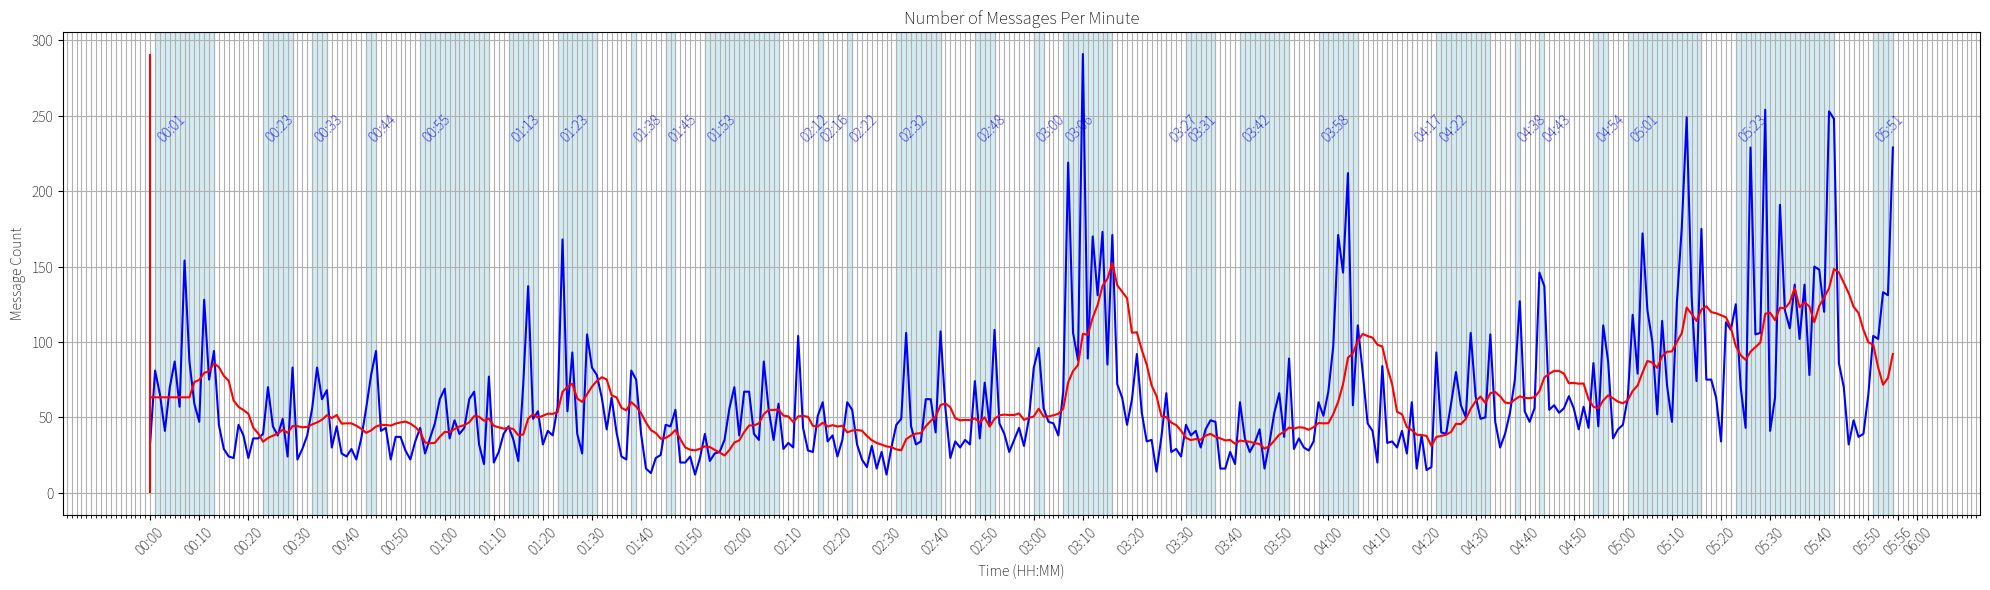

In [21]:
plt.figure(figsize=(20, 6))

plt.plot(chat.df_per_min['time_in_minutes'], chat.df_per_min['messages'], label='Total Messages', color='blue')

plt.plot(chat.df_per_min['time_in_minutes'], chat.df_per_min['messages_moving_avg'], label="Moving Average", color='red')

for start, end in chat.activity_ranges:
    plt.axvspan(start, end, color='lightblue', alpha=0.5)
    plt.text(start, chat.df_per_min['messages'].max() * 0.8, minutes_to_hhmm(start), color='blue', fontsize=10, rotation=45)

plt.vlines(0, ymin=0, ymax=chat.df_peaks['messages'].max(), colors='red')

plt.xticks(ticks=env_.time_labels[1], labels=env_.time_labels[0], rotation=45)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel('Time (HH:MM)')
plt.ylabel('Message Count')
plt.title('Number of Messages Per Minute')

plt.grid(True, which='both')
plt.tight_layout()
plt.savefig(env_.chat_timeline_path)
plt.show()

In [22]:
# from stream_analysis.summary import Summary

# df_filtered = df[df['cleaned_message'].str.len() > 0]

# summary = Summary(env_, '\n'.join(df_filtered[['message']].to_numpy().flatten())).getContent()
# summary

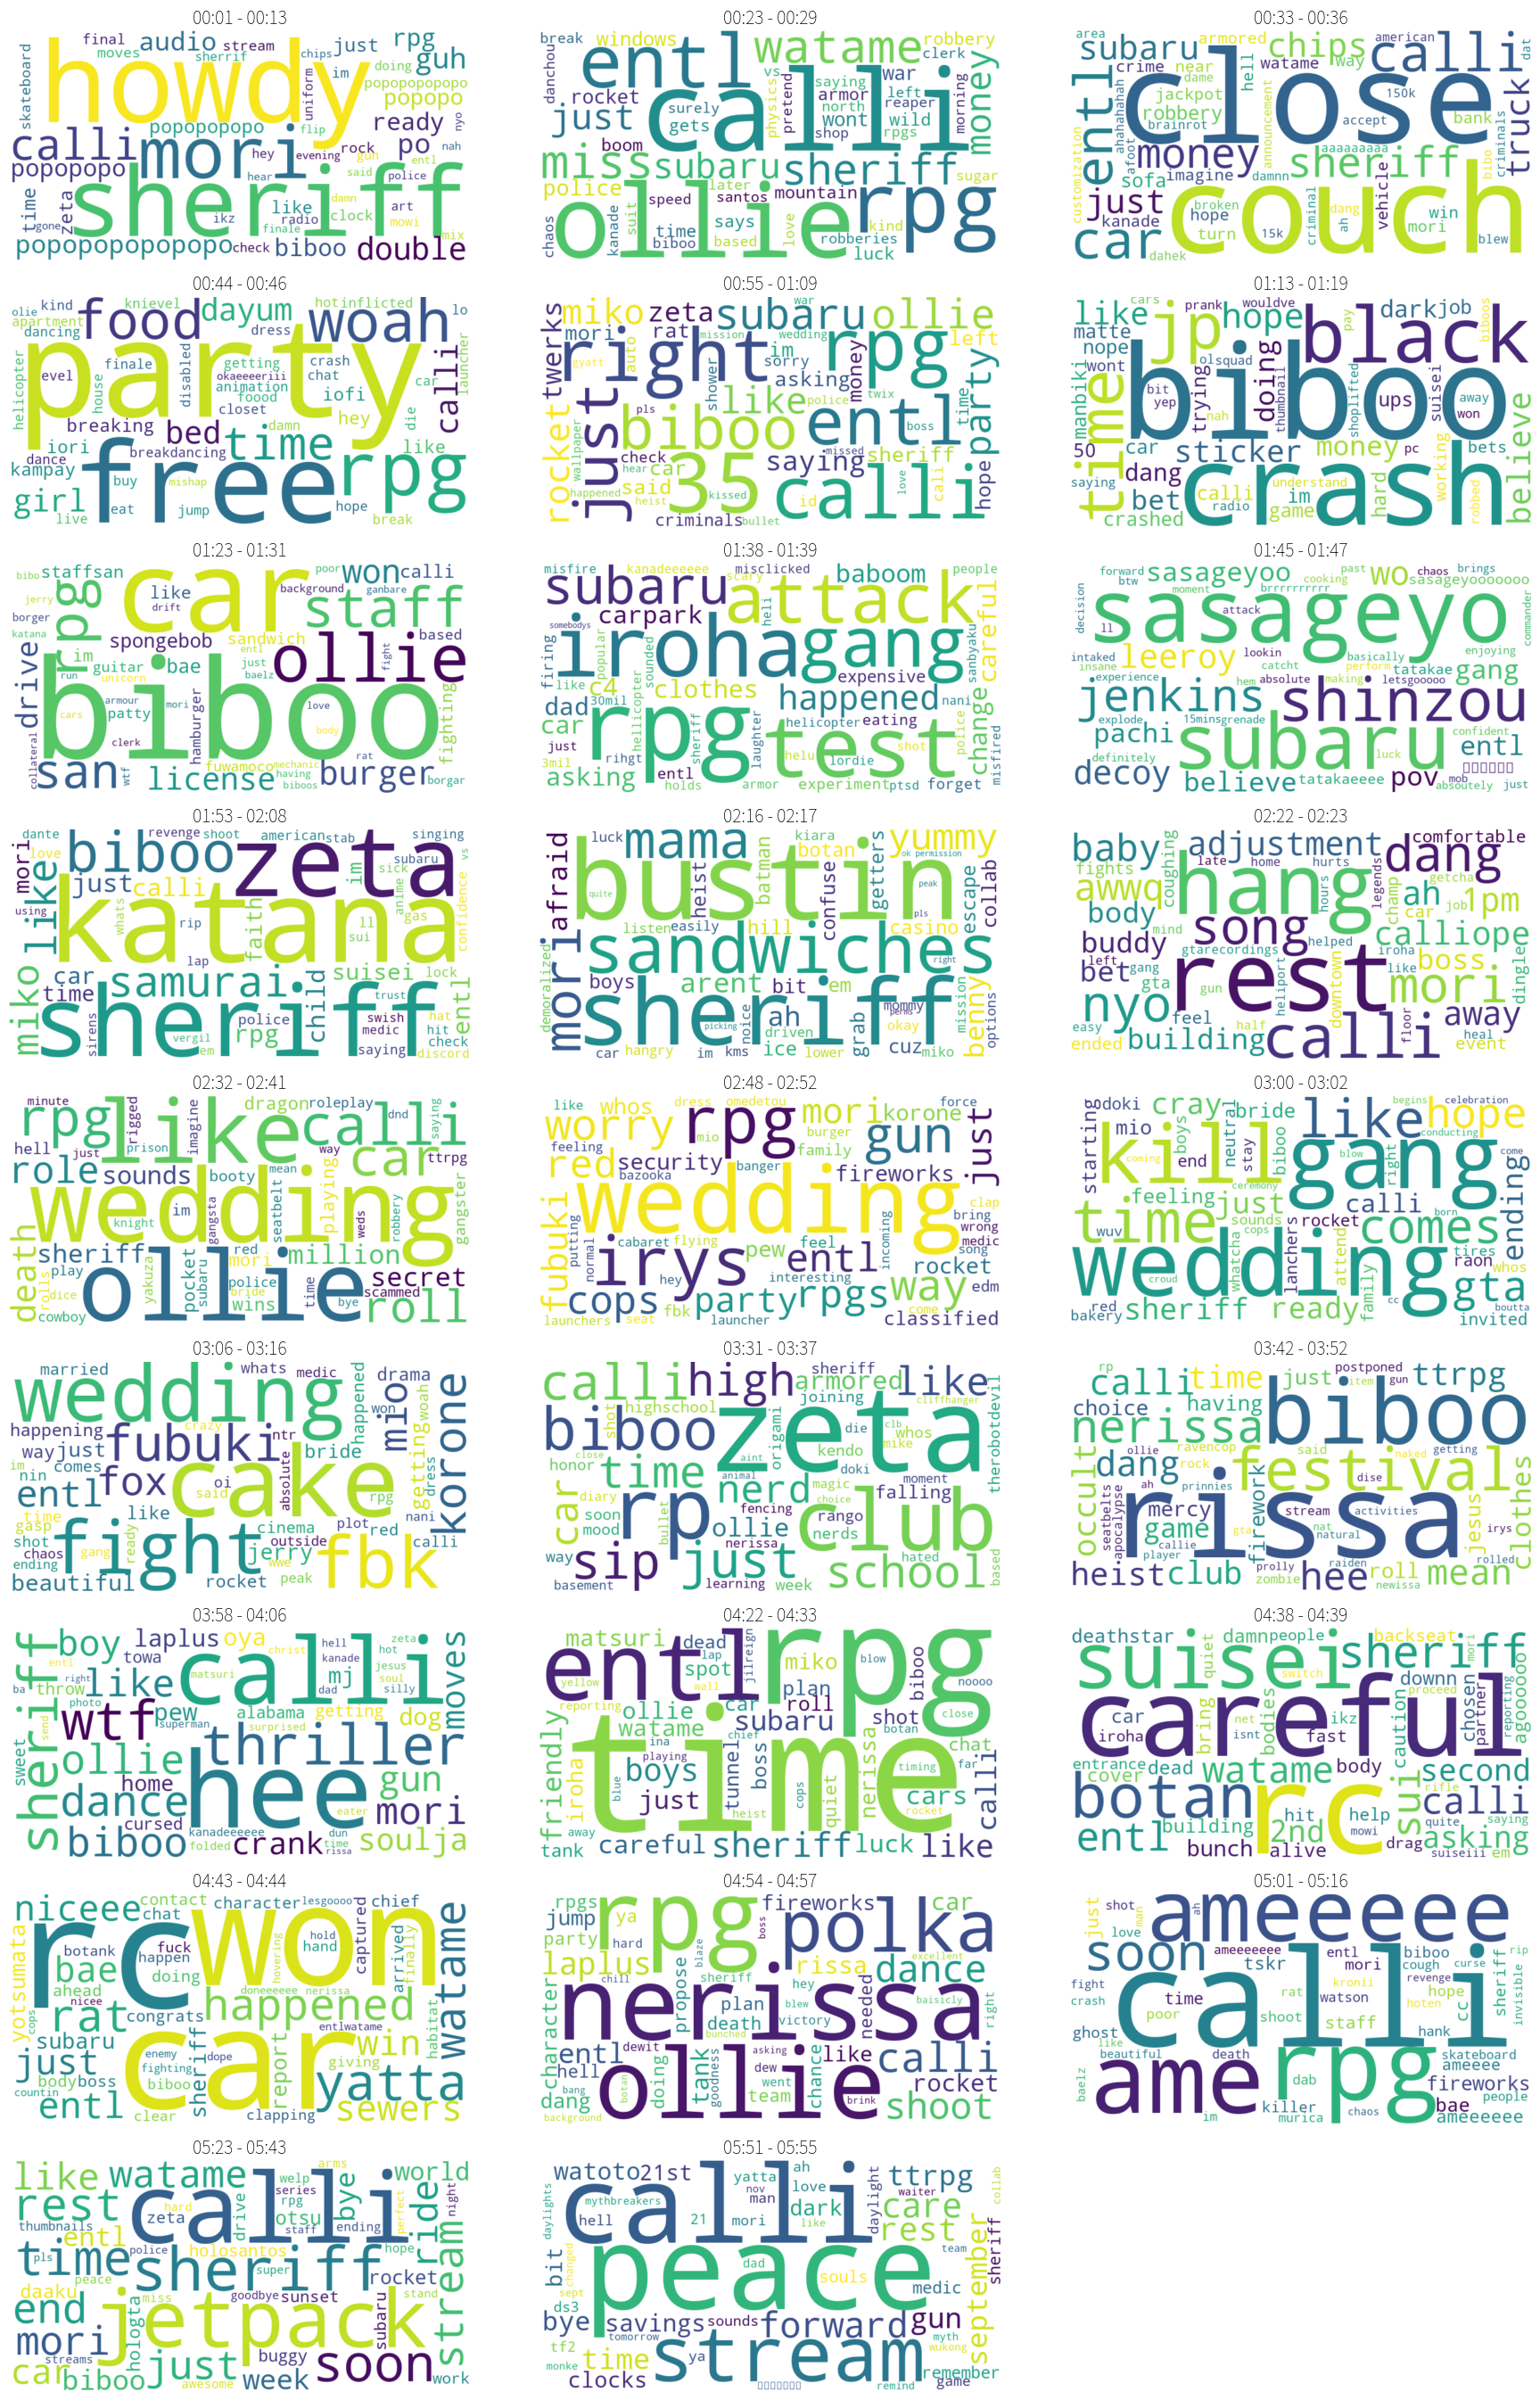

In [23]:
num_intervals = len(chat.activity_ranges)
cols = 3
rows = math.ceil(num_intervals / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, 3 * rows))

index = -1
for i, time_range in enumerate(chat.activity_ranges):
    try:
        index += 1
        start = time_range[0] * 60
        end = time_range[1] * 60
        start_label = minutes_to_hhmm(time_range[0])
        end_label = minutes_to_hhmm(time_range[1])

        df_filtered = df[(df['time_in_seconds'] >= start) & (df['time_in_seconds'] <= end) & (df['cleaned_message'].str.len() > 0)]

        word_freq = get_word_freq(df_filtered['cleaned_message'])
        word_path = os.path.join(env_.data_path, f'{start_label}_{end_label}'.replace(':', '-'))
        wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, min_word_length=3).generate_from_frequencies(word_freq)

        df_filtered[['time_in_seconds', 'message']].to_csv(f'{word_path}_chat.csv', encoding='utf8', index=False)
        word_freq.to_csv(f'{word_path}_wfreq.csv', encoding='utf8', header=False)

        ax = axes[index // cols][index % cols] if rows > 1 else axes[index % cols]

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")

        ax.set_title(f'{start_label} - {end_label}', fontsize=14)
    except Exception as e:
        index -= 1
        continue

for j in range(index + 1, rows * cols):
    fig.delaxes(axes[j // cols][j % cols] if rows > 1 else axes[j % cols])

plt.tight_layout()
plt.savefig(env_.chat_wordcloud_path)
plt.show()

In [24]:
font_name = os.getenv('DEFAULT_FONT_NAME')
font_path = f"{os.getenv('DEFAULT_FONT_PATH')}/{font_name}/{os.getenv('DEFAULT_FONT_FILENAME')}"
pdfmetrics.registerFont(TTFont(font_name, font_path, 'utf8'))

c = canvas.Canvas(os.path.join(env_.data_path, 'report.pdf'), pagesize=A4)

width, height = A4
cursor = height
margin = 8
available_width = width - 2 * margin

c.setFont(font_name, 16)

cursor = height - 32

text_width = c.stringWidth(env_.video_title)
x_position = (available_width - text_width) / 2  # 計算置中位置

c.drawString(x_position, cursor, env_.video_title)

c.setFont(font_name, 12)
cursor = cursor - 17
text_width = c.stringWidth(env_.video_liver)
x_position = (available_width - text_width)
c.drawString(x_position, cursor, env_.video_liver)

# cursor = cursor - 10
# cursor = draw_markdown_to_pdf(c, summary, cursor, margin, width, height, font_name)

image = ImageReader(env_.chat_timeline_path)
img_width, img_height = image.getSize()

# 計算圖片縮放比例，保持等比例縮放
scale_factor = available_width / img_width
scaled_width = available_width
scaled_height = img_height * scale_factor

# 如果圖片的高度超過頁面，則根據頁面的高度進行縮放
if scaled_height > height:
    scale_factor = height / img_height
    scaled_height = height
    scaled_width = img_width * scale_factor

# 計算圖片位置（居中顯示圖片）
x_position = margin  # 左右保持 8px 的空格
cursor = y_position = cursor - scaled_height - 10

# 插入圖片
c.drawImage(image, x_position, y_position, width=scaled_width, height=scaled_height)

image = ImageReader(env_.chat_wordcloud_path)
img_width, img_height = image.getSize()

# 計算圖片縮放比例，保持等比例縮放
scale_factor = available_width / img_width
scaled_width = available_width
scaled_height = img_height * scale_factor

# 如果圖片的高度超過頁面，則根據頁面的高度進行縮放
if scaled_height > height:
    scale_factor = height / img_height
    scaled_height = height
    scaled_width = img_width * scale_factor

# 計算圖片位置（居中顯示圖片）
x_position = margin  # 左右保持 8px 的空格
cursor = y_position = cursor - scaled_height - 10

# 插入圖片
c.drawImage(image, x_position, y_position, width=scaled_width, height=scaled_height)

c.save()
